In [1]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForMaskedLM

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils import resample

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [2]:
import torch
torch.cuda.empty_cache() 

* https://huggingface.co/avichr/heBERT
* https://huggingface.co/onlplab/alephbert-base
* https: //huggingface.co/dicta-il/dictabert
* https://huggingface.co/dicta-il/BEREL
* https://huggingface.co/dicta-il/BEREL_2.0


In [3]:
model_names = [
     'dicta-il/BEREL', 
     #'dicta-il/BEREL_2.0',
     #'avichr/heBERT', 
     #'onlplab/alephbert-base', 
     #'dicta-il/dictabert'
              ]



In [4]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
}

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

pentateuch = [
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy'
]

poetry_in_prose = [
    ('Genesis', 49),
    ('Exodus', 15), 
    ('Deuteronomy', 32), 
    ('Deuteronomy', 33), 
    ('Judges', 5), 
    ('2_Samuel', 22),
    ('Job', 1), 
    ('Job', 2),
    ('Job', 42)
]

#('Numbers 23:7' : 'Num 23:10'], 
#                 df['Num 23:18' : 'Num 23:24'], 
#                 df['Num 24:3' : 'Num 24:9'], 
#df['Num 24:15' : 'Num 24:24'], 

In [5]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

In [6]:
def make_n_clause_dict(n):
    n_clause_genre_dict = {}
    bo_ch_list = []

    for bo in F.otype.s('book'):
        book = T.sectionFromNode(bo)[0]
        if book not in genre_dict:
            continue

        chapters = L.d(bo, 'chapter')
        for ch in chapters:
            _, ch_number = T.sectionFromNode(ch)
            cl_n_grams = list(make_n_grams(L.d(ch, 'clause'), n))
        
            for cl_n_gram in cl_n_grams:
                words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
                heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
                n_clause_genre_dict[(book, cl_n_gram, genre_dict.get(book))] = heb_text
                bo_ch_list.append((book, ch_number))

    return n_clause_genre_dict, bo_ch_list

In [7]:
#del A
#del F, L, T

In [8]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def get_hidden_states(heb_texts_n, model, tokenizer):
    hidden_states = []
    for idx, texts_chunk in enumerate(heb_texts_n):
        tokenized_inputs = tokenizer(texts_chunk, max_length=128, truncation=True, padding=True, return_tensors="pt")
        tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
        with torch.no_grad():
            outputs = model(**tokenized_inputs)
            last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
            hidden_states.append(last_hidden_states)

    return hidden_states

def calculate_mean_hidden_states(hidden_states):
    hidden_states_mean = []

    for hs in hidden_states:
        bi_clause_states= np.mean(hs, 1)
        hidden_states_mean.append(bi_clause_states)

    all_embeddings = np.concatenate(hidden_states_mean, axis=0)
    return all_embeddings

def make_genre_list(n_clause_genre_dict, bo_ch_list, poetry_in_prose):
    all_genres = []
    for (_, _, genre), bo_ch in zip(n_clause_genre_dict.keys(), bo_ch_list):
        if genre == 'prose':
            if bo_ch in poetry_in_prose:
                all_genres.append(1)
            else:
                all_genres.append(0)
        elif genre == 'poetry':
            all_genres.append(1)
        elif genre == 'Jeremiah':
            all_genres.append(2)

    return all_genres

def split_prose_poetry_end_jer_embeddings(all_genres, all_embeddings, bo_ch_list):
    pr_po_idx = [idx for idx, value in enumerate(all_genres) if value != 2]
    pr_po_labels = np.array([value for idx, value in enumerate(all_genres) if value != 2])

    prose_poetry_embeddings = all_embeddings[pr_po_idx,:]
    jer_embeddings = np.delete(all_embeddings, pr_po_idx, axis=0)

    pr_po_bo_ch_list = [(bo, ch) for genre, (bo, ch) in zip(all_genres, bo_ch_list) if genre != 2]
    return prose_poetry_embeddings, pr_po_labels, jer_embeddings, pr_po_bo_ch_list


def split_deut_non_deut_end_jer_embeddings(all_genres, all_embeddings, bo_ch_list):
    
    pentateuch_indices = [idx for idx, (bo, ch) in enumerate(bo_ch_list) if bo in pentateuch]
    deut_non_deut_labels = []
    for bo, ch in bo_ch_list:
        if bo in pentateuch and bo == 'Deuteronomy':
            deut_non_deut_labels.append(1)
        elif bo in pentateuch and bo != 'Deuteronomy':
            deut_non_deut_labels.append(0)
        else:
            continue
    deut_non_deut_labels = np.array(deut_non_deut_labels)

    pentateuch_embeddings = all_embeddings[pentateuch_indices,:]

    pent_bo_ch_list = [(bo, ch) for (bo, ch) in bo_ch_list if bo in pentateuch]
    return pentateuch_embeddings, deut_non_deut_labels, pent_bo_ch_list

def upsample_minority_class(X_train, y_train):
    X_train = pd.DataFrame(X_train)
    X_train['label'] = y_train

    poetry = X_train[X_train.label == 1]
    prose = X_train[X_train.label == 0]

    poetry_upsample = resample(poetry,
             replace=True,
             n_samples=len(prose),
             random_state=42)

    all_upsampled = pd.concat([poetry_upsample, prose])

    X_train = all_upsampled.drop('label', axis=1)
    y_train = all_upsampled['label']
    return X_train, y_train

def train_rf_classifier(X_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    return rf

def make_predictions(classifier, data):
    return classifier.predict(data)

def calculate_accuracy(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

In [11]:
def split_in_train_test(prose_poetry_embeddings, pr_po_labels, test_size, pr_po_bo_ch_list):
    """
    Splits in train and test set based on whole chapters, to avoid overlap between sliding windowing clause sequences.
    """
    bo_ch_train, bo_ch_test = train_test_split(pd.Series(list(set(pr_po_bo_ch_list))), test_size=test_size, random_state=42)
    bo_ch_train = list(bo_ch_train)
    bo_ch_test = list(bo_ch_test)
    train_indices = [idx for idx, bo_ch in enumerate(pr_po_bo_ch_list) if bo_ch in bo_ch_train]
    test_indices = [idx for idx, bo_ch in enumerate(pr_po_bo_ch_list) if bo_ch in bo_ch_test]

    prose_poetry_embeddings_train = prose_poetry_embeddings[train_indices,:]
    prose_poetry_embeddings_test = prose_poetry_embeddings[test_indices,:]

    pr_po_labels_train = pr_po_labels[train_indices]
    pr_po_labels_test = pr_po_labels[test_indices]
    
    return prose_poetry_embeddings_train, prose_poetry_embeddings_test, pr_po_labels_train, pr_po_labels_test    

In [12]:
for model_name in model_names:

    for i in range(3, 4):
        print('Number of clauses is:', i)
        print('Model:', model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = BertForMaskedLM.from_pretrained(model_name, 
                                            return_dict_in_generate=True, 
                                            output_hidden_states=True).to(device)
        model.eval()

        n_clause_genre_dict, bo_ch_list = make_n_clause_dict(i)
        heb_texts = list(n_clause_genre_dict.values())
        heb_texts_n = split_evenly(heb_texts, 1000)
        print('Retrieving embeddings')
        hidden_states = get_hidden_states(heb_texts_n, model, tokenizer)
        mean_embeddings = calculate_mean_hidden_states(hidden_states)
        print('Make genre list')
        all_genres = make_genre_list(n_clause_genre_dict, bo_ch_list, poetry_in_prose)
        prose_poetry_embeddings, pr_po_labels, jer_embeddings, pr_po_bo_ch_list = split_prose_poetry_end_jer_embeddings(all_genres, mean_embeddings, bo_ch_list)
        pentateuch_embeddings, deut_non_deut_labels, pent_bo_ch_list = split_deut_non_deut_end_jer_embeddings(all_genres, mean_embeddings, bo_ch_list)
        
        print('Split in train test')
        #X_train, X_test, y_train, y_test = split_in_train_test(prose_poetry_embeddings, pr_po_labels, 0.2, pr_po_bo_ch_list)

        X_train, X_test, y_train, y_test = split_in_train_test(prose_poetry_embeddings, pr_po_labels, 0.2, pr_po_bo_ch_list)
        X_train, y_train = upsample_minority_class(X_train, y_train)
        
        #X_train, X_test, y_train, y_test = split_in_train_test(pentateuch_embeddings, deut_non_deut_labels, 0.2, pent_bo_ch_list)
        #X_train, y_train = upsample_minority_class(X_train, y_train)
        
        print('Training classifier')
        classifier = train_rf_classifier(X_train, y_train)
        y_pred = make_predictions(classifier, X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        crosstable = pd.crosstab(y_test, y_pred)

        print(model_name, accuracy)
        print(crosstable)
        print()

        del model
        del classifier

Number of clauses is: 1
Model: dicta-il/dictabert


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/dictabert 0.8268101761252447
col_0     0    1
row_0           
0      3177   99
1       609  203

Number of clauses is: 2
Model: dicta-il/dictabert
Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/dictabert 0.8437037037037037
col_0     0    1
row_0           
0      3192   53
1       580  225

Number of clauses is: 3
Model: dicta-il/dictabert
Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/dictabert 0.8569292123629113
col_0     0    1
row_0           
0      3169   45
1       529  269

Number of clauses is: 4
Model: dicta-il/dictabert
Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/dictabert 0.8706592853548062
col_0     0    1
row_0           
0      3141   42
1       472  319



In [21]:
jer_preds = list((rf.predict(jer_embeddings)))
#jer_preds

NameError: name 'rf' is not defined

### PCA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [14]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [15]:
pcs = pca_pl.fit_transform(pentateuch_embeddings)

In [16]:
pcs

array([[-2.2776732 ,  1.5105028 , -1.8609772 , -0.9024495 , -3.7395225 ,
         3.8685749 ],
       [-1.2971705 ,  0.6807528 ,  0.11902806, -3.0428689 , -3.2688446 ,
         4.3816524 ],
       [ 0.6129596 ,  2.384144  , -0.7454767 , -5.3419733 ,  1.5606843 ,
         2.9371765 ],
       ...,
       [-7.074496  ,  2.694291  , -8.377173  ,  2.2887025 , -0.25824744,
        -1.9557813 ],
       [-2.79589   , -2.1088674 , -8.281233  , -0.87680155,  1.962126  ,
        -3.4691033 ],
       [-2.762607  ,  0.10836975, -8.976531  , -2.7640052 ,  1.0403733 ,
        -7.305398  ]], dtype=float32)

In [18]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = deut_non_deut_labels


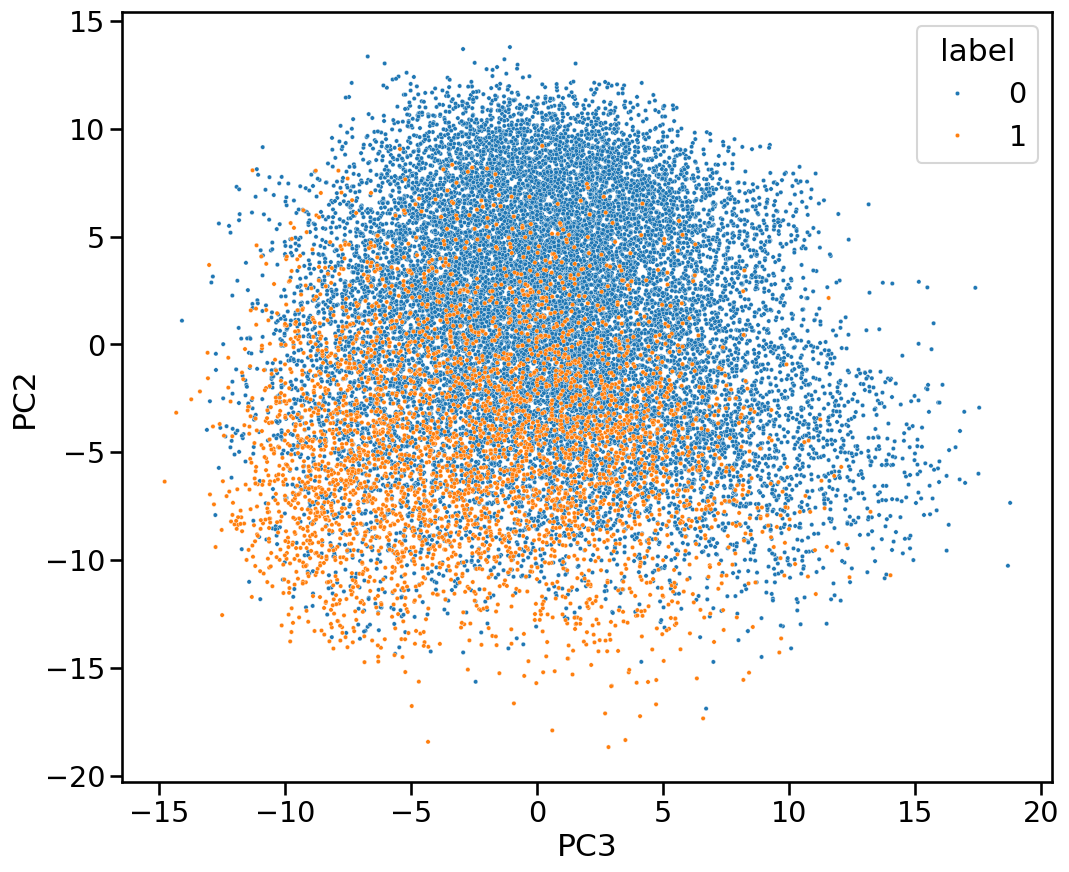

In [21]:
comp1 = 'PC3'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = deut_non_deut_labels


plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)